In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

std_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

std_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=std_transforms)
trainloader = torch.utils.data.DataLoader(std_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

validset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=std_transforms)
validloader = torch.utils.data.DataLoader(validset, batch_size=4,
                                         shuffle=False, num_workers=2)

# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

# the order for cifar10 10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(device)
print(len(std_trainset))
print(len(trainloader))  
# If 'mps or cuda:0' is printed, it means GPU is available.

Files already downloaded and verified
Files already downloaded and verified
mps
50000
12500


#### Optional: Apply data augmentation

In [88]:
from custom_cifar10 import CustomCIFAR10
from torchvision.datasets import CIFAR10

# Additional focused augmentations
focused_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

# using custom dataset class to add focused augmentations capability
aug_trainset = CustomCIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=std_transforms,
    focused_transform=focused_augmentations
)

# the class we want the augmentation for birds, cats, deer, and dogs
desired_classes = [1, 2, 3, 4]

# Filter the dataset
filtered_indices = [i for i, (_, label) in enumerate(aug_trainset) if label in desired_classes]

filtered_dataset = torch.utils.data.Subset(aug_trainset, filtered_indices)

# Combine the two datasets
combined_trainset = torch.utils.data.ConcatDataset([std_trainset, filtered_dataset])
trainloader = torch.utils.data.DataLoader(combined_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
print(len(combined_trainset))
print(len(trainloader))


Files already downloaded and verified
70000
17500


In [89]:
from pathlib import Path
from cnn_cifar_10.models import DenseMax

epoch_start = 0     # Start from epoch 0 or last checkpoint epoch
iter_n = len(trainloader)  # number of iteration per epoch
record_freq = 100 # how many times to record the loss and accuracy per epoch
print_freq = 100 # Print frequency, need to be multiple of record_freq.
iter_n_per_record = iter_n // record_freq  # Record frequency.
iter_n_per_print = iter_n // print_freq # Print frequency, need to be multiple of record_freq.

# a number for computing running validation loss in each iteration.
train_per_valid = len(trainloader) / len(validloader)  

avg_train_losses, avg_valid_losses = [], []   # Avg. losses.
train_accuracies, valid_accuracies = [], []  # Train and test accuracies.

dense_max = DenseMax()     # Create the network instance.
# Move the network parameters to the specified device
# need to be done before passing to optimizer.
dense_max.to(device)  

assert dense_max(torch.randn(4, 3, 32, 32).to(device)).shape == torch.Size([4, 10])

# We use Adam as optimizer.
opt = optim.Adam(dense_max.parameters(), lr=5e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss() 

# add scheduling
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

# directory to save the model
directory_path = Path("./models/dense_max")
# Make the directory if it doesn't exist
directory_path.mkdir(parents=True, exist_ok=True)


In [91]:
import re

# Pattern to match the files and extract epoch numbers
pattern = r'epoch_(\d+).pth'

# Use Path.glob to list all files matching the pattern
files = list(directory_path.glob('epoch_*.pth'))

# Extract epochs and files into a list of tuples
epoch_files = []
for file_path in files:
    match = re.search(pattern, file_path.name)
    if match:
        epoch_num = int(match.group(1))
        epoch_files.append((epoch_num, file_path))

# Sort the list by epoch number in descending order
epoch_files.sort(key=lambda x: x[0], reverse=False)

if epoch_files:
    # populating history for loss and accuracy for plotting
    for file in epoch_files:
        checkpoint = torch.load(file[1])
        avg_train_losses += checkpoint['avg_train_losses']
        avg_valid_losses += checkpoint['avg_valid_losses']
        train_accuracies.append(checkpoint['train_accuracy'])
        valid_accuracies.append(checkpoint['valid_accuracy'])
    
    # load the model from the latest checkpoint file
    latest_file_path = epoch_files[-1][1]
    print(f"The latest checkpoint file is: {latest_file_path}")
    checkpoint = torch.load(latest_file_path)
    dense_max.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    # start training from the next epoch
    epoch_start = checkpoint['epoch'] + 1
else:
    print("No checkpoint files found.")
        

The latest checkpoint file is: models/dense_max/epoch_0039.pth


In [80]:
epochs = 1  # Total epochs.

for epoch in range(epoch_start, epoch_start + epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    running_val_loss = 0.0     # Initialize running train_loss for validation set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    valid_total = 0   
    valid_correct = 0
    
    print('--> [Start of epoch {}]'.format(epoch) +
          '  lr: {:.6f}'.format(scheduler.get_last_lr()[0]))
    
    # print('--> [Start of epoch {}]'.format(epoch))
    
    validiter = iter(validloader)
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Set the model to training mode.
        dense_max.train()
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = dense_max(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        
        dense_max.eval()
        
        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, train_predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()
        
        # only iterate through validation set according to train_per_valid ratio
        if i % train_per_valid == train_per_valid - 1:
            # Set the model to evaluation mode.
            with torch.no_grad():
                valid_inputs, valid_labels = next(validiter)
                valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
                valid_output = dense_max(valid_inputs)
                valid_loss = loss_func(valid_output, valid_labels)
                running_val_loss += valid_loss.item()
                
                _, valid_predicted = torch.max(valid_output.data, 1)
                valid_total += valid_labels.size(0)
                valid_correct += (valid_predicted == valid_labels).sum().item()
            
        # Record training/validation loss every several mini-batches.
        if i % iter_n_per_record == iter_n_per_record - 1: 
            avg_train_loss = running_train_loss / iter_n_per_record
            avg_train_losses.append(avg_train_loss)
            avg_valid_loss = train_per_valid * running_val_loss / iter_n_per_record
            avg_valid_losses.append(avg_valid_loss)
            running_train_loss, running_val_loss = 0.0, 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % iter_n_per_print == iter_n_per_print - 1:
                print('[epoch: {}, i: {:5d}]'.format(epoch, i) +
                      '  train_loss: {:.3f}'.format(avg_train_loss) + 
                      '  |  valid_loss: {:.3f}'.format(avg_valid_loss))
                            

    # exponential scheduling
    scheduler.step()
                   
    # calculating train accuracy
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    valid_accuracy = 100 * valid_correct / valid_total
    valid_accuracies.append(valid_accuracy)     
    
    # Store the networks after each epochs.
    # in case we want to do simple average or weighted average
    file_name = f'epoch_{epoch:04d}.pth'
    save_path = directory_path / file_name
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': dense_max.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'avg_train_losses': avg_train_losses[epoch * iter_n_per_record : (epoch + 1) * iter_n_per_record],
            'avg_valid_losses': avg_valid_losses[epoch * iter_n_per_record : (epoch + 1) * iter_n_per_record],
            'train_accuracy': train_accuracies[epoch],
            'valid_accuracy': valid_accuracies[epoch],
            }, save_path)
    
    print('--> [End of epoch {}]'.format(epoch) +
                      ' train_accuracy: {:.2f}%'.format(train_accuracy) + 
                      '  |  valid_accuracy: {:.2f}%'.format(valid_accuracy))

print('Finished Training.')

--> [Start of epoch 0]  lr: 0.000500
[epoch: 0, i:   174]  train_loss: 2.098  |  valid_loss: 2.217
[epoch: 0, i:   349]  train_loss: 1.916  |  valid_loss: 1.987
[epoch: 0, i:   524]  train_loss: 1.863  |  valid_loss: 1.946
[epoch: 0, i:   699]  train_loss: 1.799  |  valid_loss: 1.771
[epoch: 0, i:   874]  train_loss: 1.768  |  valid_loss: 1.807
[epoch: 0, i:  1049]  train_loss: 1.792  |  valid_loss: 1.757
[epoch: 0, i:  1224]  train_loss: 1.658  |  valid_loss: 1.656
[epoch: 0, i:  1399]  train_loss: 1.656  |  valid_loss: 1.668
[epoch: 0, i:  1574]  train_loss: 1.660  |  valid_loss: 1.538
[epoch: 0, i:  1749]  train_loss: 1.603  |  valid_loss: 1.440
[epoch: 0, i:  1924]  train_loss: 1.641  |  valid_loss: 1.495
[epoch: 0, i:  2099]  train_loss: 1.671  |  valid_loss: 1.528
[epoch: 0, i:  2274]  train_loss: 1.613  |  valid_loss: 1.568
[epoch: 0, i:  2449]  train_loss: 1.693  |  valid_loss: 1.576
[epoch: 0, i:  2624]  train_loss: 1.643  |  valid_loss: 1.451
[epoch: 0, i:  2799]  train_loss:

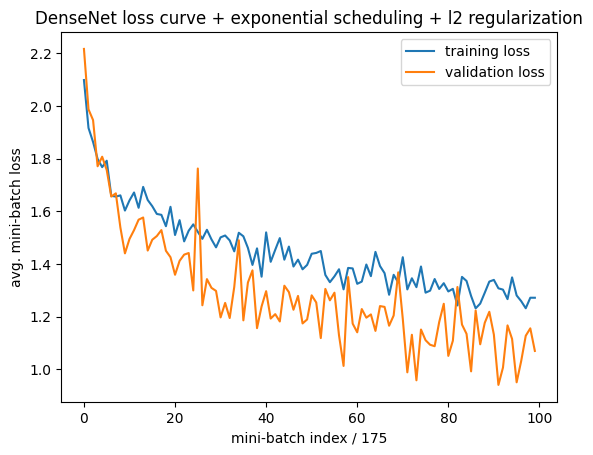

In [81]:
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('DenseNet loss curve + exponential scheduling + l2 regularization')
plt.xlabel('mini-batch index / {}'.format(iter_n_per_record))
plt.ylabel('avg. mini-batch loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

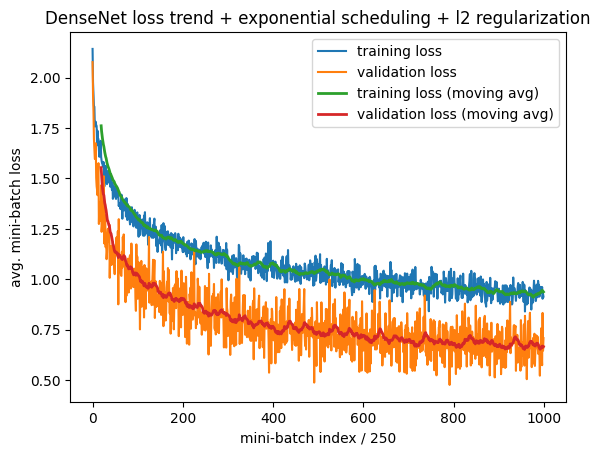

In [56]:
def moving_average(data, window_size):
    """Compute the moving average of the data using a specified window size."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 20  # Adjust this based on your preference
train_losses_ma = moving_average(avg_train_losses, window_size)
valid_losses_ma = moving_average(avg_valid_losses, window_size)

# x_axis = np.arange(len(train_losses_ma))/100 
x_axis = np.arange(window_size - 1, len(train_losses_ma) + window_size - 1)

plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.plot(x_axis, train_losses_ma, linewidth=2)
plt.plot(x_axis, valid_losses_ma, linewidth=2)
plt.title('DenseNet loss trend + exponential scheduling + l2 regularization')
plt.xlabel('mini-batch index / {}'.format(iter_n_per_record))
plt.ylabel('avg. mini-batch loss')
plt.legend(['training loss', 'validation loss', 'training loss (moving avg)', 'validation loss (moving avg)'])
plt.show()

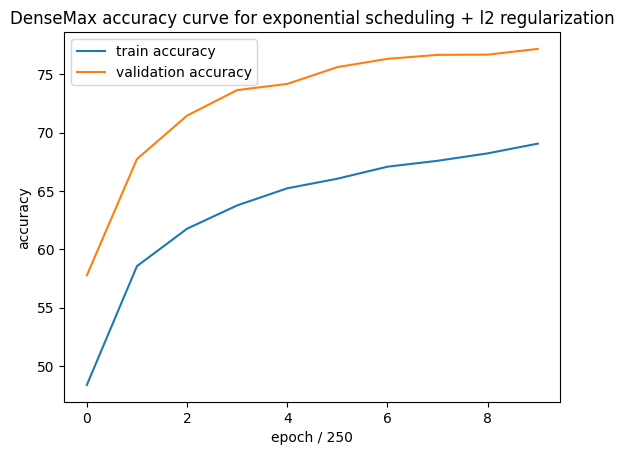

In [57]:
plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.title('DenseMax accuracy curve for exponential scheduling + l2 regularization')
plt.xlabel('epoch / {}'.format(iter_n_per_record))
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [58]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

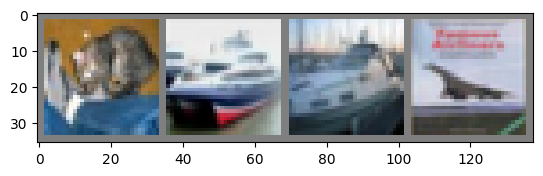

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [59]:
# Check several images.
dataiter = iter(validloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = dense_max(images.to(device))

# max compare along the row, return the index of the max value, which is the predicted class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [60]:
dense_max.to(device)
dense_max.eval()
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = dense_max(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 77.02 %


In [82]:
dense_max.to(device)
dense_max.eval()

# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = dense_max(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 86 %
Accuracy of  bird : 55 %
Accuracy of   cat : 42 %
Accuracy of  deer : 50 %
Accuracy of   dog : 57 %
Accuracy of  frog : 79 %
Accuracy of horse : 57 %
Accuracy of  ship : 77 %
Accuracy of truck : 61 %
